In [1]:
import camb
import matplotlib.pyplot as plt
import numpy as np
from camb import model, initialpower

In [53]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency

pars.set_cosmology(H0=67.7, ombh2=0.02247, omch2=0.11923, omk=0, tau=0.06)
pars.InitPower.set_params(As=2.10732e-9, ns=0.96824, r=0)

In [54]:
pars.set_for_lmax(2500, lens_potential_accuracy=0)
results = camb.get_results(pars)
cl1 = results.get_lens_potential_cls(lmax=2000)
# non linear power spectrum
pars.set_for_lmax(2500, lens_potential_accuracy=4);
results = camb.get_results(pars)
cl2 = results.get_lens_potential_cls(lmax=2000)

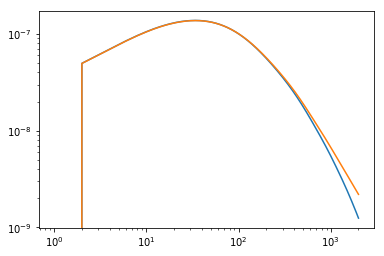

In [55]:
plt.figure()
plt.loglog(np.arange(2001), cl1[:,0])
plt.loglog(np.arange(2001), cl2[:,0])

In [56]:
nz = 100
kmax = 10
#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up arrage in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- model.tau_maxvis.value
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

In [57]:
 #Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*win/k**4)
cl_kappa*= (ls*(ls+1))**2

In [58]:
 #Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_kappa2=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa2[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*win/k**4)
cl_kappa2*= (ls*(ls+1))**2

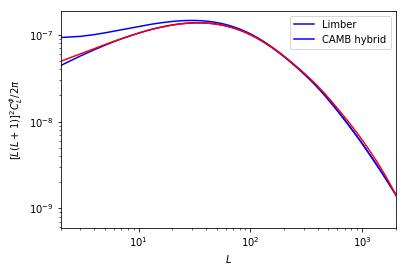

In [59]:


#Compare with CAMB's calculation:
#note that to get CAMB's internal calculation accurate at the 1% level at L~2000, 
#need lens_potential_accuracy=2. Increase to 4 for accurate match to the Limber calculation here
pars.set_for_lmax(2500,lens_potential_accuracy=0)
results = camb.get_results(pars)
cl_camb=results.get_lens_potential_cls(2500) 
#cl_camb[:,0] is phi x phi power spectrum (other columns are phi x T and phi x E)

#Make plot. Expect difference at very low-L from inaccuracy in Limber approximation, and
#very high L from differences in kmax (lens_potential_accuracy is only 2, though good by eye here)
cl_limber= 4*cl_kappa/2/np.pi #convert kappa power to [l(l+1)]^2C_phi/2pi (what cl_camb is)
ell=np.arange(2,cl_camb[:,0].size)
cl_limber2= 4*cl_kappa2/2/np.pi
plt.loglog(ls,cl_limber, color='b')
plt.loglog(ls,cl_limber2, color='b')
plt.loglog(ell,cl_camb[2:,0], color='r')
plt.xlim([2,2000])
plt.legend(['Limber','CAMB hybrid'])
plt.ylabel('$[L(L+1)]^2C_L^{\phi}/2\pi$')
plt.xlabel('$L$');



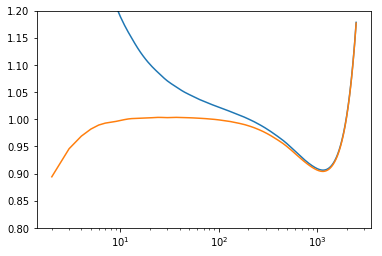

In [62]:
cl_limber = np.interp(ell,ls,cl_limber)
cl_limber2= np.interp(ell,ls,cl_limber2)
plt.figure()
plt.semilogx(ell,cl_limber/cl_camb[2:,0])
plt.plot(ell,cl_limber2/cl_camb[2:,0])
plt.ylim(0.8,1.2)

np.savetxt('camb_cls.out',X=(ell,cl_limber,cl_limber2,cl_camb[2:,0]))